In [1]:
%matplotlib notebook

In [2]:
from genelife import *
import genelife_update_module as genelife


## Python-C link:

Build genlife scheme with xcode using ../fastgenegol.xcodeproj/
* scheme genelifed (confusing?)
* target genelife with source `subgenelife.c` (see in Build Phases)

Then
```
ln -s ../Build/Products/Release/libgenelife.dylib libgenelife.dylib
```

**Careful:**  make sure that Xcode is setup to compile in the Release directory.  (Could be set to Debug directory, in which cased the link above would have to change.


Then
```
python genelife.py
```

#### Changing lattice size:
Change `log2N`:
* line 23 in `subgene.c`, 
* line 10 in `genelifeNd.py`.

#### Variation by NP for gathering stats:
display ndisp, run for nrun without display, repeat:
|---ndisp---|------------------nrun---------------|
e.g. ndisp=100, nrun = 1000

python genelifeN.py

## Deterministic vs. nondeterministic code:

`genelife.ipynb` uses deterministic code.

`genelifed.ipynb` uses non-deterministic code.

`genelifed.ipynb` may be switched to non-deterministic by changing line 356 of `subgenelife4d.c` (to call either `update_nondet()` or `update_det()`), recompiling, and restarting the python kernel. A future commit can set this as a configuration parameter... Note however that non deterministic action is erroneous in update_nondet, and achievable instead with update_det (now just update) by means of the repscheme == 0 option.


## Older, pre-python C link:

Activity graph:
```
cc -o actgenegol actgenegol.c

acitivity.py actgenegol
```

## Dynamics:

default: display 200; iterate 1000; repeat

```
cc -o dispgenegol dispgenegol.c

display.py dispgenegol
```

## Jupyter notebook

In the current directory ruyn `jupyter notebook`, then in the browser window that pops up look for `genelife.ipynb` and open it.  Execute cells down to the *Animation* section, and watch the animation.




## Initialization

The code determining the effect of genes on birth, and the mutation of genomes is currently on lines 229-242 of `subgene.c`.

Five replication schemes for case of 3 live nbrs:
* repscheme == 0: random choice of live nbr for replication 
* repscheme == 1: deterministic bitwise XOR, replication of 'most different' live nbr
* repscheme == 2: deterministic consensus seq, replication of 'most different' live nbr
* repscheme == 3: deterministic choice: replication of live nbr with unique position
* repscheme == 4: same as 3, more complex version.


* each site update, random number `randnr` is chosen and has multiple uses:
   *  bits 54-55 random ancestor (e.g. for `repscheme==0` in 3 nbr case), 
   *  bits 48-53 mut pos for mutating the genome, 
   *  bits 24-47 mut probability, 
   *  bits 0-23 rule departure prob
   
* gene (bits -0-23 of `randnr`) specifies 8 8-bit counters, each with max value 7.
* param `selection`
* param `rulemod=1` => genetically alteration of GOL rule kicks in for 3 nbrs giving birth:
* param `nlog2p0` fixes probability that
    * Number of ones (`nones`) is computed for genes of each live nbr (using `CUMCOUNT64C()`)
    * minimum value over nbrs is chosen
    * compute `nlog2p = nlog2p0 + nones`
    * create `pmask` = `nlog2p` bits
    * set `r1=1`  if lowest `nlog2p` bits of `randnr` are 0 (1 with probability $1/2^{\rm nlog2p}$
    * birth if empty and ((s==3) or (s==2 and `r1`)) 
* param `nlog2pmut` fixes mutation probability

In [3]:
offsets = [[0,0,0],
       [-1, 0, 0],
       [-1, 1, 0],
       [0, 1, 0],
       [1, 1, 0],
       [1, 0, 0],
       [1, -1, 0],
       [0, -1, 0],
       [-1, -1, 0]]
numHis = pow(2,len(offsets))
histo=np.zeros(numHis,np.uint64)

simparams = np.zeros(5,np.int32)    # 5 parameters passed to C
nlog2p0   = simparams[0] = 8
nlog2pmut = simparams[1] = 8
selection = simparams[2] =  1            # values 0,1,2 allowed
rulemod  = simparams[3] =  1            # values 0,1 allowed
initial1density = simparams[4] = 16384   # nearest to half of guaranteed C rand max value 32767 = 2**15 - 1


In [4]:
flatoff =  [x for sublist in offsets for x in sublist]
npoffsets = np.array(flatoff,np.int32)
genelife.initialize_planes(npoffsets)

genelife.initialize(simparams)

genelife.initialize_genes(simparams)

## Animation

<IPython.core.display.Javascript object>


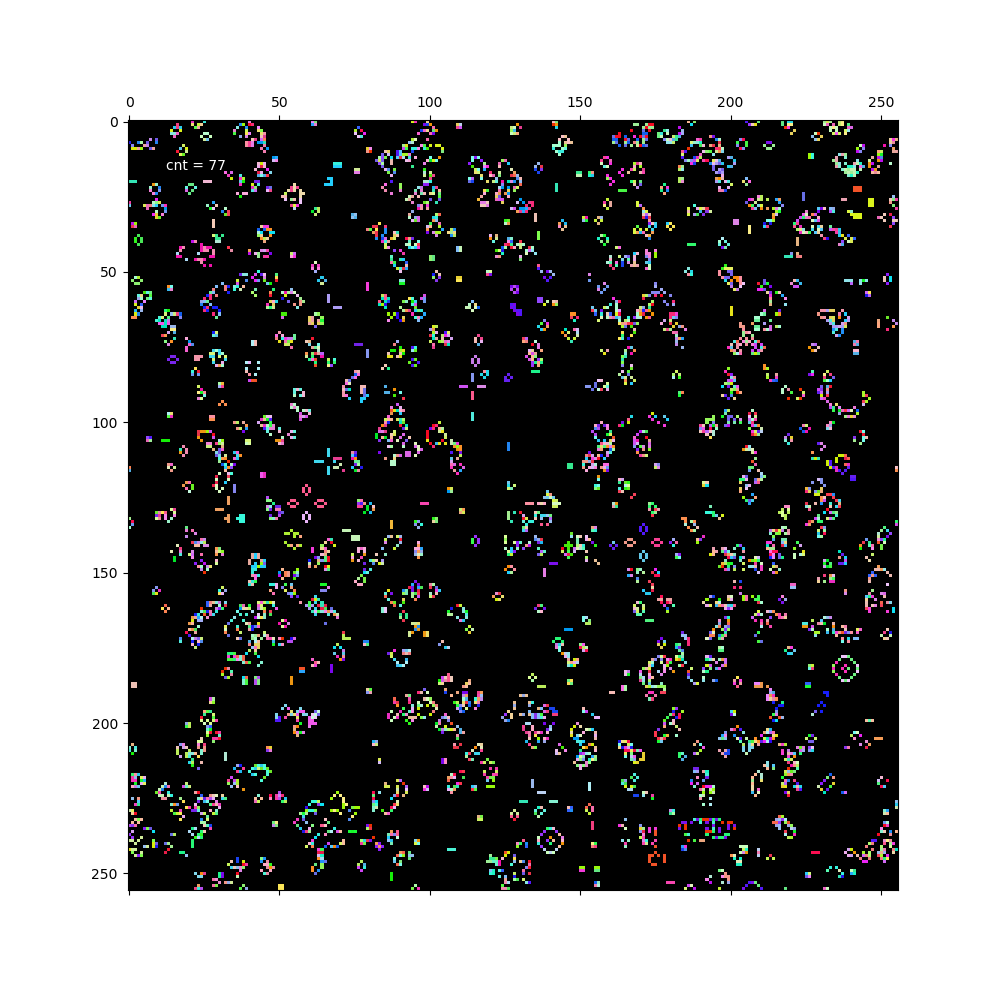

In [5]:
#def doanimation(nrun=1,ndisp=1000,niter=1):    
nrun=1; ndisp=1000; niter=1
fig, ax = plt.subplots(figsize=(10,10))

time_text = ax.text(0.05, 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
colorgrid(N)
def update_anim(data):
    global gol, cgrid
    global golg
    global log2N
    global simparams
    global cnt
    global framenr
    global mat
    cnt = cnt+1
    #if cnt % ndisp == 0:  # insert the non-displayed iterations
    genelife.genelife_update(gol, golg, log2N, nrun, simparams,0)
    framenr = framenr+nrun
    colorgrid(N)
    mat.set_data(cgrid)
    time_text.set_text('cnt = %.1d' % framenr)
    time_text.set_color('w')
    return mat

mat = ax.matshow(cgrid, cmap=my_cmap, vmin=0.01, vmax=257)  # was vmax = LEN+1
ani = animation.FuncAnimation(fig, update_anim, interval=60, # ~60 ms to see every time step
                              save_count=0, frames=niter*ndisp, repeat = False)
plt.show()


In [16]:
[histo[i] for i in [x+128 for x in range(256)]]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
